In [32]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# **Data Collection**

In [33]:
# Microsoft data for the last four years
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=4*365)
df=yf.download("MSFT",start=start_date,end=end_date)

[*********************100%***********************]  1 of 1 completed


# **Preprocessing the Data**

In [34]:
print(df.head())

Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2021-01-13  209.118164  209.524142  206.788611  206.875618  20087100
2021-01-14  205.908997  210.200783  205.638345  208.702522  29480800
2021-01-15  205.551315  207.349225  204.952017  206.392283  31746500
2021-01-19  209.214828  209.736796  205.532016  206.614623  30480900
2021-01-20  216.851074  218.252667  210.036415  210.432731  37777300


Checking for any missing values

In [35]:
print(df.isnull().any().any())

False


Checking for data types in the coloumns

In [36]:
print(df.dtypes)

Price   Ticker
Close   MSFT      float64
High    MSFT      float64
Low     MSFT      float64
Open    MSFT      float64
Volume  MSFT        int64
dtype: object


Convert the date column to a datetime object and set it as the index.

I think this is already the case for the data downloaded, I will jsut go ahead and print the index.

In [37]:
print(df.index)

DatetimeIndex(['2021-01-13', '2021-01-14', '2021-01-15', '2021-01-19',
               '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-25',
               '2021-01-26', '2021-01-27',
               ...
               '2024-12-26', '2024-12-27', '2024-12-30', '2024-12-31',
               '2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-10'],
              dtype='datetime64[ns]', name='Date', length=1004, freq=None)


Filter and retain only the closing price or a similar indicator for analysis.

In [38]:
df.drop(columns=['Open', 'High','Volume','Low'], inplace=True)

In [39]:
df.head()

Price,Close
Ticker,MSFT
Date,
2021-01-13,209.118164
2021-01-14,205.908997
2021-01-15,205.551315
2021-01-19,209.214828
2021-01-20,216.851074


Normalize the data between 0 and 1 for LSTM implementation.

I am going to duplicate this dataframe and keep the original one.

In [40]:
dfnew=df.copy()

using the max-min scaling, from sklearn

In [41]:
scaler = MinMaxScaler()
dfnew['Close Normalized'] = scaler.fit_transform(dfnew[['Close']])
dfnew.drop(columns=['Close'],inplace=True)

Split the data into training (80%) and testing (20%) sets.

In [42]:

index_value=int(0.8*(int(df.shape[0])))
training_df=df[:index_value]
testing_df=df[index_value:]
training_dfnew=dfnew[:index_value]
testing_dfnew=dfnew[index_value:]

# **ARIMA Model**

Making the data stationary for GRID SEARCH in ARIMA model

In [43]:
train_data_diff = training_df['Close'].diff().dropna()

Visually checking stationarity

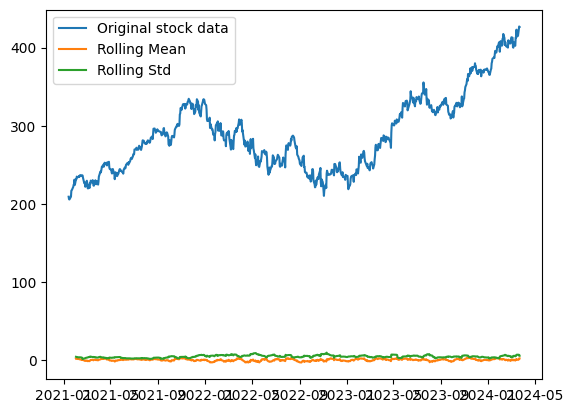

In [44]:
window = 12
rolling_mean = train_data_diff.rolling(window=window).mean()
rolling_std = train_data_diff.rolling(window=window).std()

plt.plot(training_df, label='Original stock data')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.show()


As the rolling mean and standard deviation are almost constant, let's proceed onto making the ACF and PACF plots for moving average order and autoregressive order estimation

<Figure size 1200x600 with 0 Axes>

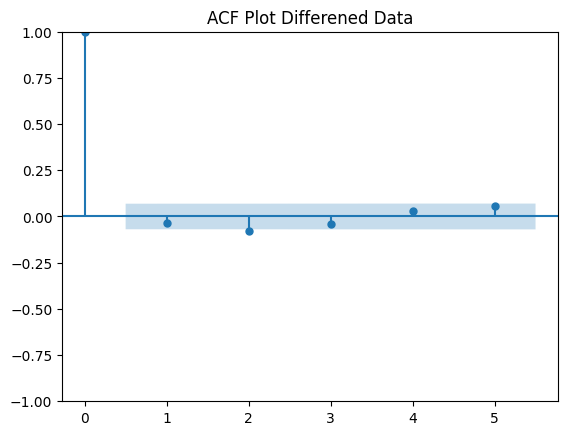

In [45]:
plt.figure(figsize=(12, 6))
plot_acf(train_data_diff, lags=5)
plt.title("ACF Plot Differened Data")
plt.show()

<Figure size 1200x600 with 0 Axes>

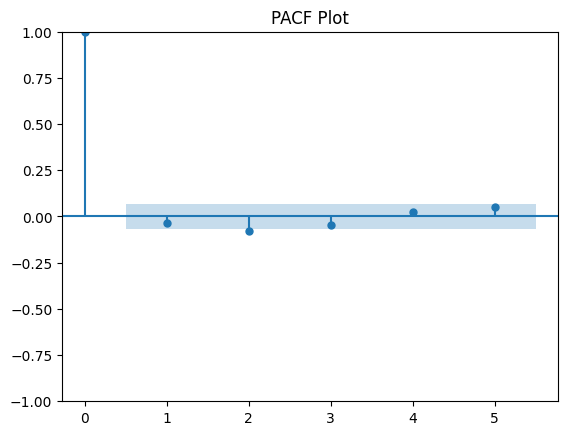

In [46]:
plt.figure(figsize=(12, 6))
plot_pacf(train_data_diff, lags=5)
plt.title("PACF Plot")
plt.show()

Now let's implement the grid search method for ARIMA model and I will restrict ranges to 5

In [47]:
def grid_search_arima(series, p_range, d_range, q_range):
    best_aic = np.inf
    best_order = None
    for p in p_range:
      for q in q_range:
        for d in d_range:
          model=ARIMA(series,order=(p,d,q)).fit()
          if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, d, q)
    return best_order


best_order = grid_search_arima(training_df, p_range=range(5), d_range=range(3), q_range=range(5))
print("Optimal ARIMA order:", best_order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal ARIMA order: (2, 1, 3)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The output is :- "Optimal ARIMA order: (2,1,3)", which completes our ARIMA model.

In [48]:
final_model=ARIMA(training_df,order=(2,1,3)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [49]:
print(final_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_MSFT   No. Observations:                  803
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2388.306
Date:                Sun, 12 Jan 2025   AIC                           4788.613
Time:                        17:32:03   BIC                           4816.736
Sample:                             0   HQIC                          4799.415
                                - 803                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1699      0.057      2.955      0.003       0.057       0.283
ar.L2         -0.9129      0.050    -18.285      0.000      -1.011      -0.815
ma.L1         -0.2105      0.067     -3.158      0.0

**Forecasting**

In [50]:
forecast = final_model.forecast(steps=testing_df.shape[0])
y_points=np.array(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [51]:
x_points=testing_df.index.to_numpy()

Plot the actual vs. predicted values for the test dataset.

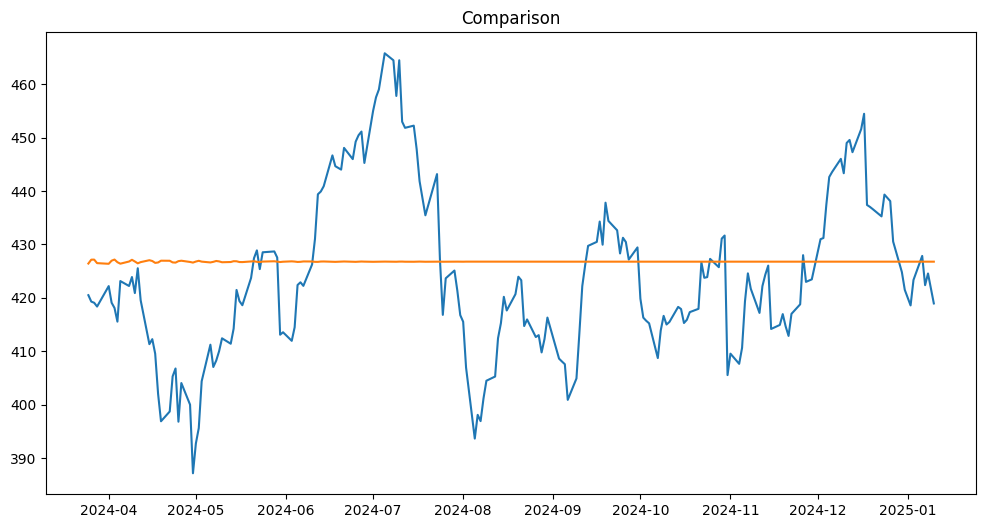

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(testing_df)
plt.plot(x_points,y_points)
plt.title("Comparison")
plt.show()

In [53]:
true_values=np.array(testing_df)

In [54]:
residual=final_model.resid
print(residual)

Date
2021-01-13    209.118164
2021-01-14     -3.208994
2021-01-15     -0.473298
2021-01-19      3.486847
2021-01-20      7.596773
                 ...    
2024-03-18      0.982448
2024-03-19      3.474102
2024-03-20      3.230920
2024-03-21      4.868348
2024-03-22      0.571798
Length: 803, dtype: float64


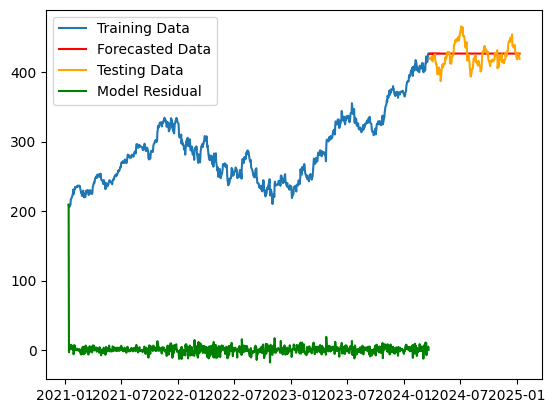

In [55]:
plt.plot(training_df['Close'],label='Training Data')
plt.plot(x_points,y_points,color='red', label='Forecasted Data')
plt.plot(testing_df,color='orange',label='Testing Data')
plt.plot(residual,color='green',label='Model Residual')
plt.legend(loc='best')
plt.show()

# **LSTM Model**

Use a sliding window approach to convert the time series data into supervised learning format.

<ipython-input-56-541213011c4d>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y.append(data['Close Normalized'][i+n])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0658 - val_loss: 0.0044
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0012 - val

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


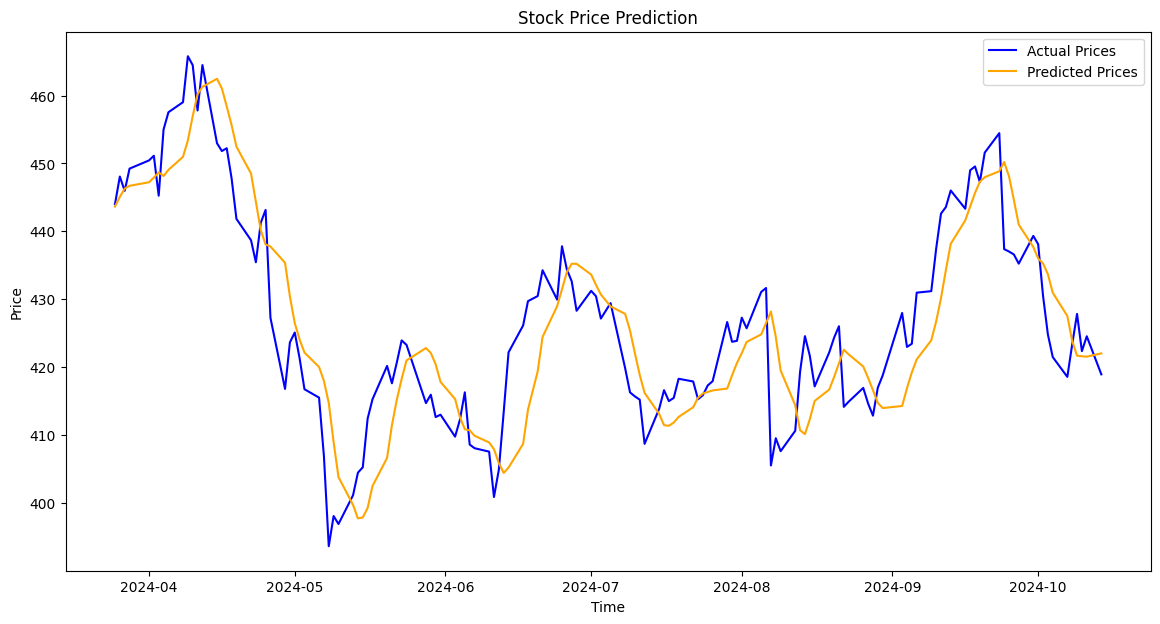

In [56]:
# working on df new
# I will write a fuction which will give two input parameters for training data
# n is the window size

#constants
window_size= 60
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001



def rolling_window(data,n):
  X=[]
  Y=[]
  size=len(data)
  for i in range(size-n):
    X.append(data['Close Normalized'][i:i+n])
    Y.append(data['Close Normalized'][i+n])
  return np.array(X),np.array(Y)

data_X_train,data_Y_train=rolling_window(training_dfnew,window_size)
data_X_test,data_Y_test=rolling_window(testing_dfnew,window_size)

data_X_train = data_X_train.reshape(data_X_train.shape[0], data_X_train.shape[1], 1)
data_X_test = data_X_test.reshape(data_X_test.shape[0], data_X_test.shape[1], 1)


model_LSTM = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer_LSTM = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_LSTM.compile(optimizer=optimizer_LSTM, loss='mse')
history_LSTM = model_LSTM.fit(data_X_train, data_Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(data_X_test, data_Y_test))



loss_LSTM = model_LSTM.evaluate(data_X_test, data_Y_test)
print(f"Test Loss: ",loss_LSTM)


y_pred_LSTM = model_LSTM.predict(data_X_test)
y_pred_actual_LSTM = scaler.inverse_transform(y_pred_LSTM)
y_test_actual = scaler.inverse_transform(data_Y_test.reshape(-1, 1))


plt.figure(figsize=(14, 7))
plt.plot(testing_dfnew.index[:testing_dfnew.shape[0]-window_size],y_test_actual, label='Actual Prices', color='blue')
plt.plot(testing_dfnew.index[:testing_dfnew.shape[0]-window_size],y_pred_actual, label='Predicted Prices', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Model with Dropouts to prevent overfitting.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0469 - val_loss: 0.0031
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0022 - val_

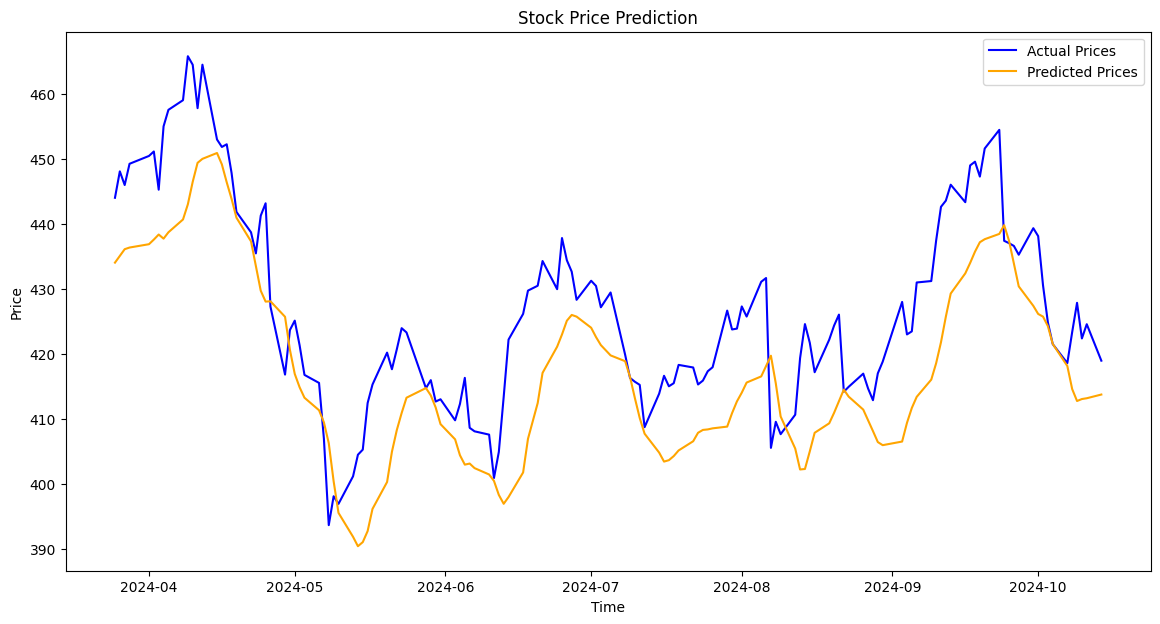

In [57]:

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mse')
history = model.fit(data_X_train, data_Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(data_X_test, data_Y_test))



loss = model.evaluate(data_X_test, data_Y_test)
print(f"Test Loss: ",loss)


y_pred = model.predict(data_X_test)
y_pred_actual = scaler.inverse_transform(y_pred)


plt.figure(figsize=(14, 7))
plt.plot(testing_dfnew.index[:testing_dfnew.shape[0]-window_size],y_test_actual, label='Actual Prices', color='blue')
plt.plot(testing_dfnew.index[:testing_dfnew.shape[0]-window_size],y_pred_actual, label='Predicted Prices', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# **Bidirectional LSTM Implementation**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - loss: 0.0512 - val_loss: 0.0165
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0017 - 

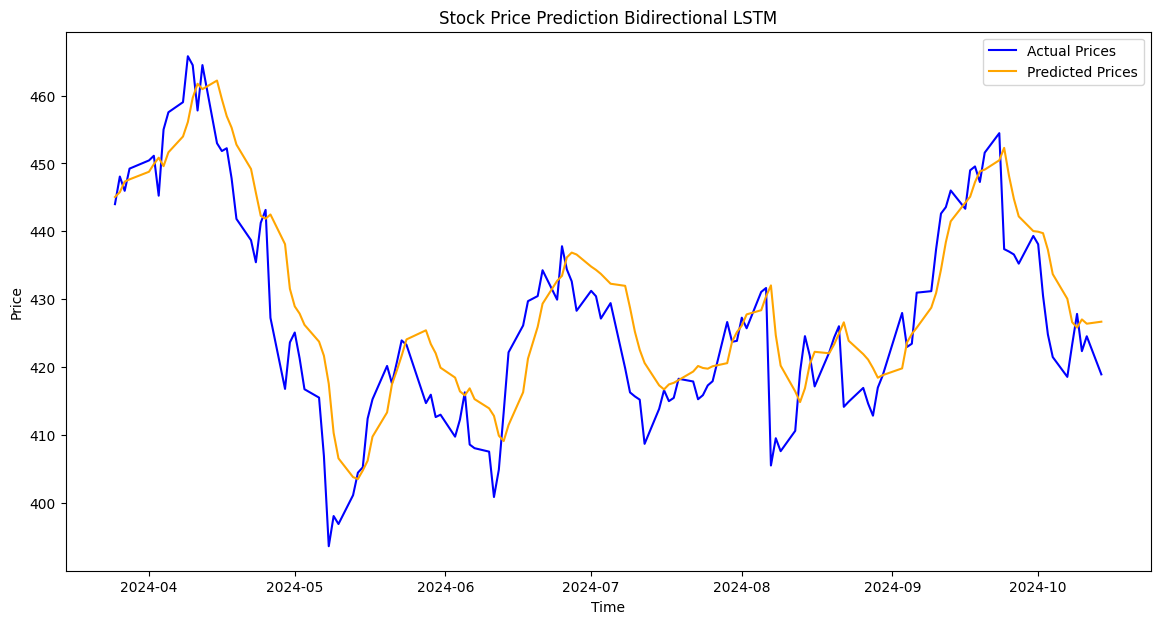

In [58]:
from tensorflow.keras.layers import Bidirectional
model_1= Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(window_size, 1))),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_1.compile(optimizer=optimizer_1, loss='mse')
history_1 = model_1.fit(data_X_train, data_Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(data_X_test, data_Y_test))



loss_1 = model_1.evaluate(data_X_test, data_Y_test)
print(f"Test Loss: ",loss_1)


y_pred_1 = model_1.predict(data_X_test)
y_pred_actual_1 = scaler.inverse_transform(y_pred_1)


plt.figure(figsize=(14, 7))
plt.plot(testing_dfnew.index[:testing_dfnew.shape[0]-window_size],y_test_actual, label='Actual Prices', color='blue')
plt.plot(testing_dfnew.index[:testing_dfnew.shape[0]-window_size],y_pred_actual_1, label='Predicted Prices', color='orange')
plt.title('Stock Price Prediction Bidirectional LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# **Comparison Between ARIMA and LSTM**

- **Mean Absolute Error (MAE)**.
- **Root Mean Squared Error (RMSE)**.
- **Mean Absolute Percentage Error (MAPE)**.

# **ARIMA**

In [59]:
true_values_1=np.array(testing_df)
mae_ARIMA = np.mean(np.abs(true_values_1 - y_points))
mse_ARIMA = np.mean((true_values_1 - y_points) ** 2)
rmse_ARIMA = np.sqrt(mse_ARIMA)
print("ARIMA:-")
print(f"MAE: {mae_ARIMA}")
print(f"MSE: {mse_ARIMA}")
print(f"RMSE: {rmse_ARIMA}")

ARIMA:-
MAE: 12.597074563995454
MSE: 242.030807478898
RMSE: 15.557339344466907


# **LSTM**

In [62]:
mae_LSTM_o = np.mean(np.abs(y_test_actual - y_pred_actual_LSTM))
mse_LSTM_o = np.mean((y_test_actual -y_pred_actual_LSTM) ** 2)
rmse_LSTM_o = np.sqrt(mse_LSTM_o)
print("LSTM:-")
print(f"MAE: {mae_LSTM_o}")
print(f"MSE: {mse_LSTM_o}")
print(f"RMSE: {rmse_LSTM_o}")

LSTM:-
MAE: 9.01724827543218
MSE: 119.07117480091117
RMSE: 10.911973918632283


In [63]:
mae_LSTM = np.mean(np.abs(y_test_actual - y_pred_actual))
mse_LSTM = np.mean((y_test_actual -y_pred_actual) ** 2)
rmse_LSTM = np.sqrt(mse_LSTM)
print("LSTM_Dropouts:-")
print(f"MAE: {mae_LSTM}")
print(f"MSE: {mse_LSTM}")
print(f"RMSE: {rmse_LSTM}")

LSTM_Dropouts:-
MAE: 9.904760049589981
MSE: 136.30095161088076
RMSE: 11.674799853140128


In [64]:
mae_LSTM_1 = np.mean(np.abs(y_test_actual - y_pred_actual_1))
mse_LSTM_1 = np.mean((y_test_actual -y_pred_actual_1) ** 2)
rmse_LSTM_1 = np.sqrt(mse_LSTM_1)
print("LSTM_Bidirectional:-")
print(f"MAE: {mae_LSTM_1}")
print(f"MSE: {mse_LSTM_1}")
print(f"RMSE: {rmse_LSTM_1}")

LSTM_Bidirectional:-
MAE: 5.840027937652372
MSE: 56.25671921087204
RMSE: 7.500447934015144


- Write an analysis of  the **strengths and weaknesses** of both models in terms of:
    - Handling seasonality and trends.
    - Ability to capture non-linear patterns.
    - Computational complexity.

I think the ARIMA model is well in capturing the mean of the data, it predicts the trend but can't predict the flactuations in data. The LSTM model captures both the flactuations and trends in data quite well and has the ability to caputre non-linear pattern.

LSTM is more computationally complex, also I think it could be made more complex by adding a grid search for constants window_size, BATCH_SIZE ,EPOCHS, LEARNING_RATE and then minimizing the loss.

# **Learning Curve for LSTM (training vs. validation loss).**

Plotting how the model evolves, by keeping the track of losses

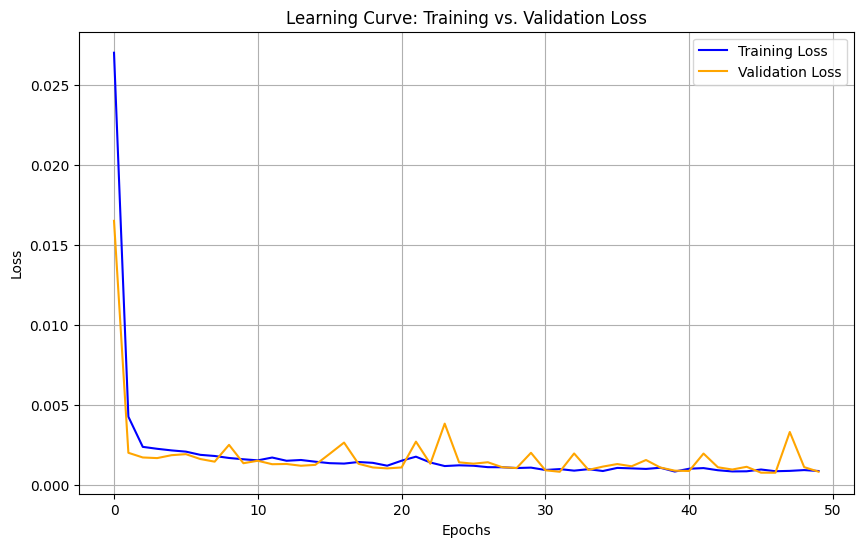

In [65]:
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']


plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve: Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
